In [ ]:
%pip install stable-baselines3[extra]
%pip install gymnasium

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class StockMarketEnv(gym.Env):
    def __init__(self, max_len=100, max_inventory=10):
        super(StockMarketEnv, self).__init__()
        self.max_len = max_len
        self.max_inventory = max_inventory
        self.action_space = spaces.Discrete(3)  # 0: wait, 1: buy, 2: sell
        self.observation_space = spaces.Box(
            shape=(self.max_inventory, 2),
            low=-np.inf, high=np.inf,
            dtype=np.float64
        )
        self.history=0
        self.history={"buy":[], "sell":[], "price":[]}
        self.reset()

    def _find_max_profit(self, array):
        assert array[:, 1].sum() > 0
        max_profit = -np.inf
        max_index = 0
        for i in range(self.max_inventory):
            if array[i, 1] == 1 and array[i, 0] > max_profit:
                max_profit = array[i, 0]
                max_index = i
        return max_index

    def reset(self, seed=0):
        self.price = 70000
        self.step_count = 0
        # 상태 정보는 현재 재고 정보와
        # 판매 시 이익량의 정보를 담고 있음.
        self.state = np.zeros((self.max_inventory, 2))
        self.portfolio = 0
        self.purchased_prices = {i: 0 for i in range(self.max_inventory)}
        self.history={"buy":[], "sell":[], "price":[]}
        return self.state, {}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        # Update portfolio and compute reward
        reward = 0
        if action == 1:  # buy
            if 0 in self.state[:, 1]:
                self.portfolio += 1
                available_index = np.where(self.state[:, 1] == 0)[0][0]
                self.purchased_prices[available_index] = self.price
                self.state[available_index, 1] = 1
                self.state[available_index, 0] = 0
                self.history["buy"].append(self.step_count)
        elif action == 2 and self.portfolio > 0:  # sell
            self.portfolio -= 1
            max_profit_item = self._find_max_profit(self.state)
            reward = self.state[max_profit_item, 0]
            self.state[max_profit_item, 0] = 0
            self.state[max_profit_item, 1] = 0
            self.history["sell"].append(self.step_count)

        # 상태 업데이트: 구매했던 가격과 현재 가격의 차이를 계산해 지금 팔면 얻을수 있는 이익값을 상태로 결정
        for i in range(self.max_inventory):
            if self.state[i, 1] == 1: #구매한 슬롯이면 
                self.state[i, 0] = self.price - self.purchased_prices[i]

        # Update price based on random walk
        # self.price += np.random.choice([-1, 1])
        self.price += np.random.randint(-50, 50)
        self.price = max(0, self.price)
        self.history["price"].append(self.price)
        self.step_count += 1
        done = self.step_count >= self.max_len
        # if done:
        #     reward += self.state[:, 0].sum()
        #     for i in range(self.max_inventory):
        #         self.state[i, 0] = 0
        #         self.state[i, 1] = 0

        return self.state, reward, done, done, {}
    
    def render(self, mode='human', close=False):
        print(f"Step: {self.step_count}")
        print(f"Price: {self.price}")
        print(f"Portfolio: {self.portfolio}")
        print(f"Max profit: {max(self.state[:, 0])}")
        print(f"State:\n{self.state}")

In [2]:
def evaluate():
    global plt
    env = StockMarketEnv()
    total_reward = 0
    state = env.reset()
    done = False
    total_reward_history=[]

    while not done:
        action = np.random.choice([0, 1, 2])
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_reward_history.append(total_reward)
        # env.render()
        # print(f"Action: {action}, Reward: {reward}\n")

    print(env.history)

    fig, price1 = plt.subplots()

    price1.plot(range(env.max_len), env.history["price"])
    selling = mpatches.Patch(color='green',label='Sell')
    buying = mpatches.Patch(color='red',label='Buy')
    pricing = mpatches.Patch(color='blue', label="Price")
    rewarding = mpatches.Patch(color='orange', label="Rewards")


    rewards = price1.twinx()
    
    rewards.plot(range(env.max_len), total_reward_history, color='orange')


    for i in env.history["buy"]:
        plt.axvline(i, color='red', alpha=0.1)
    for i in env.history["sell"]:
        plt.axvline(i, color='green', alpha=0.1)
    plt.legend(handles=[selling, buying, pricing, rewarding], loc='lower right')
    plt.show()

    return total_reward



# rewards = []
# for _ in range(100):
#     total_reward = evaluate()
#     rewards.append(total_reward)

# print(np.mean(rewards))
# print(np.max(rewards))
# print(np.min(rewards))


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

{'buy': [1, 2, 3, 4, 11, 18, 19, 21, 22, 23, 25, 26, 28, 35, 38, 39, 41, 45, 47, 51, 52, 54, 62, 65, 74, 78, 83, 87, 88, 92, 96, 97, 98], 'sell': [5, 7, 10, 12, 13, 20, 24, 30, 31, 32, 42, 43, 44, 49, 50, 53, 55, 56, 57, 58, 60, 64, 67, 69, 76, 80, 85, 91, 94], 'price': [70017, 70024, 69987, 70015, 70000, 69962, 69922, 69874, 69918, 69942, 69956, 69943, 69913, 69957, 69941, 69989, 69944, 69950, 69987, 69950, 69903, 69855, 69891, 69911, 69882, 69916, 69904, 69918, 69874, 69900, 69931, 69946, 69917, 69961, 69934, 69962, 69953, 69921, 69901, 69858, 69865, 69839, 69875, 69896, 69869, 69908, 69928, 69976, 70004, 70044, 70045, 70028, 70002, 70028, 70001, 69994, 69969, 69946, 69963, 69976, 69940, 69933, 69963, 69999, 69971, 69990, 70039, 70007, 70006, 69978, 69974, 69930, 69920, 69890, 69847, 69821, 69810, 69815, 69831, 69803, 69816, 69848, 69851, 69873, 69832, 69855, 69896, 69943, 69900, 69873, 69921, 69932, 69891, 69882, 69911, 69914, 69918, 69874, 69853, 69846]}


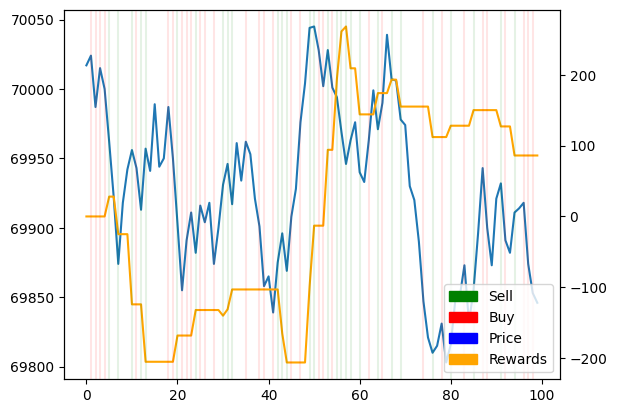

86.0

In [5]:
evaluate()

In [6]:
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.


In [7]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Create the environment
env = StockMarketEnv(max_len=1000)

# Check if the environment follows the gym interface
check_env(env, warn=True)

# Create and train the DQN agent
model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001, gamma=1)
model.learn(total_timesteps=40000)

# Save the model
model.save("dqn_stock_market")

c:\Users\repry\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -3.18e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 1033      |
|    time_elapsed     | 3         |
|    total_timesteps  | 4000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.61      |
|    n_updates        | 974       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -1.85e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8         |
|    fps              | 960       |
|    time_elapsed     | 8         |
|    total_timesteps  | 8000      |
| trai

In [16]:
def evaluate_dqn():
    # Load the model
    model = DQN.load("dqn_stock_market")

    # Test the trained model
    total_reward = 0
    env.history={"buy":[],"sell":[],"price":[]}
    obs, _ = env.reset()
    done = False
    total_reward_history=[]

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_reward_history.append(total_reward)
        # env.render()
        # print(f"Action: {action}, Reward: {reward}\n")
    
    print(env.history)

    fig, price1 = plt.subplots()

    price1.plot(range(env.max_len), env.history["price"])
    selling = mpatches.Patch(color='green',label='Sell')
    buying = mpatches.Patch(color='red',label='Buy')
    pricing = mpatches.Patch(color='blue', label="Price")
    rewarding = mpatches.Patch(color='orange', label="Rewards")

    plt.title("Random Walk Stock Market Deep Q-RL")
    rewards = price1.twinx()
    
    rewards.plot(range(env.max_len), total_reward_history, color='orange')


    for i in env.history["buy"]:
        plt.axvline(i, color='red', alpha=0.1)
    for i in env.history["sell"]:
        plt.axvline(i, color='green', alpha=0.1)
    plt.legend(handles=[selling, buying, pricing, rewarding], loc='lower right')
    plt.show()

    return total_reward


# rewards = []
# for _ in range(100):
#     total_reward = evaluate_dqn()
#     rewards.append(total_reward)

# print(np.mean(rewards))
# print(np.max(rewards))
# print(np.min(rewards))


print(evaluate_dqn())

ValueError: Error: Unexpected observation shape (100000, 2) for Box environment, please use (10, 2) or (n_env, 10, 2) for the observation shape.

In [15]:
env=StockMarketEnv(max_inventory=100000)